In [535]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

## Toy gaussian data in 2D and basic functions

In [411]:
def gaussian_data(mus, covmats, n):
    g1 = np.random.multivariate_normal(mus[0], covmats[0], int(n / 2))
    y1 = np.ones((int(n / 2), 1))
    xy1 = np.concatenate((g1, y1), axis=1)
    g2 = np.random.multivariate_normal(mus[1], covmats[1], int((n + 1) / 2))
    y2 = - np.ones((int((n + 1) / 2), 1))
    xy2 = np.concatenate((g2, y2), axis=1)
    xy = np.concatenate((xy1, xy2), axis=0)
    np.random.shuffle(xy)
    return xy                      

In [412]:
def center_and_reduce(xmat, inplace=True):
    d = xmat.shape[0]
    n = xmat.shape[1]
    xmean = np.mean(xmat, axis=1)
    xvar = np.var(xmat, axis=1)
    meanmat = np.repeat(xmean.reshape((d,1)), n, axis=1)
    varmat = np.repeat(xvar.reshape((d,1)), n, axis=1)
    if inplace :
        xmat = (1 / varmat) * (xmat - meanmat)
    else:
        return (1 / varmat) * (xmat - meanmat)

In [413]:
def data_from_label(xmat, y, label):
    indices = np.argwhere(y == label)
    return xmat[:, indices[:, 0]]

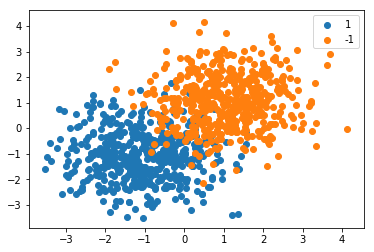

In [414]:
# Parameters for gaussian data
mus = ([-1, -1], [1, 1])
covs = (np.eye(2), np.eye(2))

# Create data
xy = gaussian_data(mus, covs, 1000)

# Separate data and labels
xmat = xy[:, :2].T
y= xy[:,2].T

# Center and reduce
center_and_reduce(xmat)

# Plot
xs_plus1 = data_from_label(xmat, y, 1)
xs_minus1 = data_from_label(xmat, y, -1)
plt.scatter(xs_plus1[0, :], xs_plus1[1, :], label="1")
plt.scatter(xs_minus1[0, :], xs_minus1[1, :], label="-1")
plt.legend()
plt.show()

## Class wrapper for loss functions
We create here an almost empty class model for losses functions. The objective is to be able to change loss function easily

In [442]:
class LossFunc:
    
    def __init__(self):
        self.primal = None
        self.dual = None
        self.sdca_update = None
        self.sgd_update = None
    
    def set_primal(self, func):
        self.primal = func
    
    def set_dual(self, func):
        self.dual = func
    
    def set_sdca_update(self, func):
        self.sdca_update = func
    
    def set_sgd_update(self, func):
        self.sgd_update = func

## Definition of Hinge loss using the LossFunc class wrapper
We define the hinge loss using the class framework defined above

In [443]:
def vector_hinge_loss(a, y):
    return np.maximum(0, 1 - y * a)

def vector_hinge_dual(alpha, y):
    prod = alpha * y
    prod[prod > 0] = np.inf
    prod[prod < -1] = np.inf
    return prod

def hinge_delta_alpha(w, xi, yi, alphai, lamb):
    n = xi.shape[0]
    q = lamb * n * (1 - np.dot(xi.T, w) * yi) / np.power(np.linalg.norm(xi), 2)
    q += alphai * yi
    return yi * max(0, min(1, q)) - alphai
    
hinge = LossFunc()
hinge.set_primal(vector_hinge_loss)
hinge.set_dual(vector_hinge_dual)
hinge.set_sdca_update(hinge_delta_alpha)

## Primal and dual of cumulative regularized loss
We define in this section:
1. Some intermediaries functions
1. The primal dual correspondance function (associating w(alpha) to alpha)
1. The primal and dual cumulative loss functions
1. The duality gap function

In [444]:
def xmatT_dot_w(xmat, w):
    return np.dot(xmat.T, w)

In [445]:
def cum_loss(w, xmat, y, lamb, lossfunc=hinge):
    a = xmatT_dot_w(xmat, w)
    cumloss = np.mean(lossfunc.primal(a, y))
    reg = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumloss + reg

In [446]:
def alpha_to_w(alpha, xmat, lamb):
    n = xmat.shape[1]
    return (1 / (n * lamb)) * np.dot(xmat, alpha)

In [447]:
def cum_loss_dual(alpha, xmat, y, lamb, lossfunc=hinge):
    cumlossdual = np.mean(- lossfunc.dual(- alpha, y))
    w = alpha_to_w(alpha, xmat, lamb)
    reg = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumlossdual + reg

In [448]:
# Test for those few first functions
w_test = np.array([1, 1])
w_test = w_test.reshape((2, 1))
a = w_dot_xmat(w_test, xmat)
h = vector_hinge_loss(a, y)
cumloss = cum_loss(w_test, xmat, y, 1)
n = xmat.shape[1]
alpha_test = 0.5 * np.ones((n,))
cum_loss_dual(alpha_test, xmat, y, 1)

-inf

In [422]:
def duality_gap(alpha, xmat, y, lamb, lossfunc=hinge):
    w = alpha_to_w(alpha, xmat, lamb)
    p = cum_loss(w, xmat, y, lamb, lossfunc)
    d = cum_loss_dual(alpha, xmat, y, lamb, lossfunc)
    return p - d

## Modified SGD for initialization

We wish to find $\alpha_t$ that maximizes : 
$$ - \phi_t^{\star}(-\alpha_t) - \frac{\lambda t}{2} ||w^{(t-1)} + (\lambda t)^{-1} \alpha_t x_t ||^2$$

Developping the previous expression yields : 
$$ \alpha_t y_t - \frac{\lambda t}{2} ( ||w^{(t-1)}||^2 + 2 \frac{\alpha_t}{\lambda t} \langle w^{(t-1)}, x_t \rangle + \frac{\alpha_t^2}{\lambda^2 t^2}||x_t||^2 )$$

This is a second order polynomial in $\alpha_t$. With a negative coefficient on the second order term. Thus this is concave. Setting the derivative w.r.t $\alpha_t$ yields : 

$$ y_t - \langle w^{(t-1)}, x_t \rangle - \frac{\alpha_t^2}{2 \lambda t} = 0$$


This gives us an optimal $\alpha_t$ which is given by : 
$$ \alpha_t= \frac{\lambda t}{||x_t||^2} (y_t - x_t^T w^{(t-1)})$$

In [423]:
def hinge_sgd_update(w, xt, yt, lamb, t):
    wdotx = np.dot(xt.T, w)
    xsqrnorm = np.power(np.linalg.norm(xt), 2)
    return ((lamb * t) / xsqrnorm) * (yt - wdotx)

hinge.set_sgd_update(hinge_sgd_update)

In [424]:
def modified_sgd(xmat, y, lamb, lossfunc=hinge):
    d = xmat.shape[0]
    n = xmat.shape[1]
    alpha = np.zeros((n, ))
    w = np.zeros((d, ))
    for t in range(0, n):
        alpha[t] = lossfunc.sgd_update(w, xmat[:, t], y[t], lamb, t)
        w = alpha_to_w(alpha[:t + 1], xmat[:, :t + 1], lamb)
    return alpha, w       

## SDCA Perm

In [ ]:
def sdca_perm_epoch(w, alpha, xmat, y, lamb, lossfunc=hinge):
    n = xmat.shape[1]
    inds = np.array(range(0, n))
    np.random.shuffle(inds)
    for j in range(0, n):
        print(i)
        i = inds[j]
        delta = lossfunc.sdca_update(w, xmat[:, i], y[i], alpha[i], lamb)
        alpha[i] += delta
        w += (1 / (lamb * n)) * delta * xmat[:, i]

In [526]:
def sdca_perm(alpha0, xmat, y, lamb, nmax_epochs, epsilon, lossfunc=hinge):
    n = xmat.shape[1]
    alpha = alpha0.copy()
    w = alpha_to_w(alpha0, xmat, lamb)
    loss_track = []
    loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
    gaps_track = []
    gap = np.inf
    k = 0
    # while (gap > epsilon) and (k < nmax_epochs) :
    while k < nmax_epochs :
        sdca_perm_epoch(w, alpha, xmat, y, lamb, lossfunc)
        k += 1
        loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
        gaps_track.append(duality_gap(alpha, xmat, y, lamb, lossfunc))
        print(k)
    return w, alpha, loss_track, gaps_track

## Deduction of a classifier

In [548]:
def classify(wstar, xmat_test):
    prod = np.dot(xmat_test.T, wstar)
    prod[prod >= 0] = 1
    prod[prod < 0] = -1
    return prod

## Test on toy gaussian 2D data

In [449]:
# First epoch using SGD
alpha0, w0 = modified_sgd(xmat_cr, y_cr, 1)
# SDCA epochs
wstar, alphastar, losses, gaps = sdca_perm(alpha0, xmat, y, 0.1, 100, 0.001)

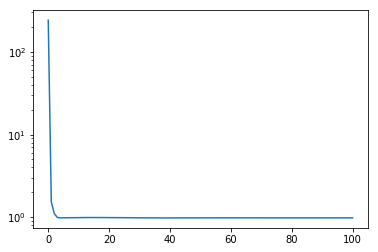

In [450]:
plt.semilogy(hist)
plt.show()

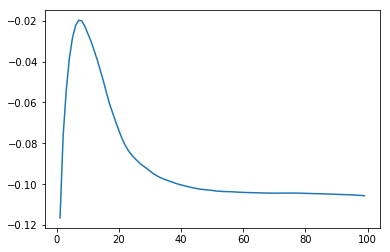

In [451]:
plt.plot(gaps)
plt.show()

In [452]:
def hyperplane(w, xgrid):
    return (-w[0] / w[1]) * xgrid

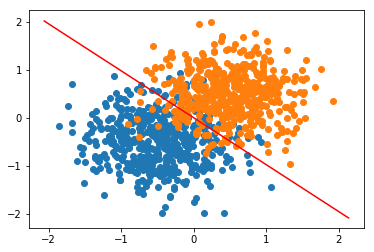

In [453]:
positive = xy_cr[xy_cr [:, 2] == 1]
negative = xy_cr[xy_cr [:, 2] == -1]
fig = plt.figure()
plt.scatter(positive[:, 0], positive[:, 1])
plt.scatter(negative[:, 0], negative[:, 1])
ax = fig.axes[0]
xlim = ax.get_xlim()
xgrid = np.linspace(xlim[0], xlim[1], 1000)
sep = (xgrid, hyperplane(wstar, xgrid))
ax.plot(sep[0], sep[1], c="r")
plt.show()

## Test on fashion item classification on the Fashion MNIST database

In [555]:
# Load fashion MNIST from computer
path = "C://Users//Dimitri//Desktop//ENSAE3A//SOADML//FashionMNIST//"
train_pd = pd.read_csv(path + "fashion-mnist_train.csv")
test_pd = pd.read_csv(path + "fashion-mnist_test.csv")

In [556]:
# Selection on 0 (t shirts) and 1 (trousers) labels
train_pd = train_pd[train_pd.label <= 1]
train_pd["label"] = train_pd["label"].replace(0, -1)
test_pd = test_pd[test_pd.label <= 1]
test_pd["label"] = test_pd["label"].replace(0, -1)

In [557]:
# Store data in numpy matrixes
train_np = train_pd.as_matrix()
ytrain = train_np[:, 0]
xtrain = train_np[:, 1:].T
test_np = test_pd.as_matrix()
ytest = test_np[:, 0]
xtest = test_np[:, 1:].T

In [538]:
# Center and reduce the data
center_and_reduce(xtrain)

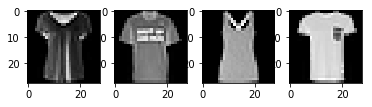

In [539]:
# Draw of few example of tshirts
example_tshirt1 = xtrain[:, 7].reshape((28, 28))
example_tshirt2 = xtrain[:, 8].reshape((28, 28))
example_tshirt3 = xtrain[:, 3].reshape((28, 28))
example_tshirt4 = xtrain[:, 17].reshape((28, 28))
fig, axes = plt.subplots(1, 4)
axes[0].imshow(example_tshirt1, cmap="gray")
axes[1].imshow(example_tshirt2, cmap="gray")
axes[2].imshow(example_tshirt3, cmap="gray")
axes[3].imshow(example_tshirt4, cmap="gray")
plt.show()

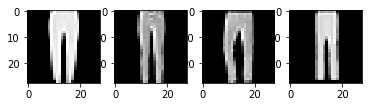

In [540]:
# Draw a few examples of trousers
example_trousers1 = xtrain[:, 4].reshape((28, 28))
example_trousers2 = xtrain[:, 9].reshape((28, 28))
example_trousers3 = xtrain[:, 11].reshape((28, 28))
example_trousers4 = xtrain[:, 22].reshape((28, 28))
fig, axes = plt.subplots(1, 4)
axes[0].imshow(example_trousers1, cmap="gray")
axes[1].imshow(example_trousers2, cmap="gray")
axes[2].imshow(example_trousers3, cmap="gray")
axes[3].imshow(example_trousers4, cmap="gray")
plt.show()

In [518]:
# First epoch using SGD
alpha0, w0 = modified_sgd(xtrain, ytrain, 0.01)

ValueError: shapes (2,1000) and (12000,) not aligned: 1000 (dim 1) != 12000 (dim 0)

In [561]:
n = xtrain.shape[1]
d = xtrain.shape[0]
alpha0 = np.zeros((n, ))
wrandom = np.random.normal(0, 1, d)

In [542]:
# SDCA epochs
wstar, alphastar, losses, gaps = sdca_perm(alpha0, xtrain, ytrain, 0.01, 50, 0.0001)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


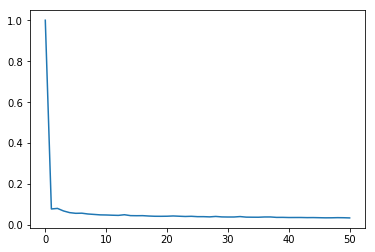

In [543]:
plt.plot(losses)
plt.show()

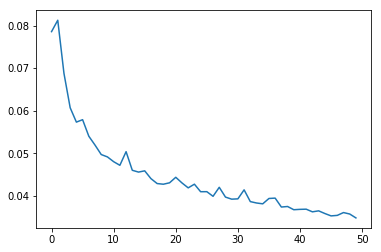

In [544]:
plt.plot(gaps)
plt.show()

In [564]:
ypred = classify(wstar, xtest)

In [565]:
ytest

array([-1,  1, -1, ..., -1, -1,  1], dtype=int64)

In [566]:
print(metrics.zero_one_loss(ypred, ytest))

0.0105
